In [1]:
import torch
from torchvision import transforms
from PIL import Image

# GPU 확인 (가능하면 GPU로)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# 1) 모델 구조 생성
#    num_classes = (배경 포함 클래스 수)
#    예를 들어, background + 공공기물 N종을 총 M개라면 num_classes=M+1
num_classes = 9
detector = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=num_classes)

# 2) state_dict 불러오기
state_dict_det = torch.load("./models/fasterrcnn_model.pt", map_location=device)
detector.load_state_dict(state_dict_det)

# 3) to(device) & eval()
detector.to(device).eval()

import torch.nn as nn
from torchvision.models import resnet50

# 1) 기본 ResNet50 구조 불러오기
classifier = resnet50(pretrained=False)

# 2) 마지막 FC 레이어 교체 (출력 차원 = 정상/파손 2개)
in_features = classifier.fc.in_features
classifier.fc = nn.Linear(in_features, 2)

# 3) state_dict 불러오기
state_dict_clf = torch.load("./models/resnet_binary.pt", map_location=device)
classifier.load_state_dict(state_dict_clf)

# 4) to(device) & eval()
classifier.to(device).eval()

print("Both models loaded and set to eval()")

/anaconda/envs/jupyter_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/jupyter_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/azureuser/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 434MB/s]


Both models loaded and set to eval()


In [5]:
# Faster‑RCNN 입력: ToTensor()
preprocess_det = transforms.Compose([
    transforms.ToTensor()
])

# ResNet 분류 입력: Resize+CenterCrop+Normalize
preprocess_clf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

tensor([4, 4, 5, 4, 4, 4, 5, 5, 5, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5], device='cuda:0')
tensor([0.9878, 0.9859, 0.9769, 0.9672, 0.9172, 0.8934, 0.8878, 0.8874, 0.8425,
        0.7819, 0.3938, 0.3346, 0.2776, 0.2403, 0.2366, 0.2326, 0.2090, 0.2055,
        0.1734, 0.1085, 0.1043, 0.0856, 0.0833, 0.0722, 0.0665, 0.0595, 0.0587],
       device='cuda:0')
Best box: [287 143 311 185] score: 0.9877959489822388
category ID: tensor(4, device='cuda:0')
Predicted class idx: 0


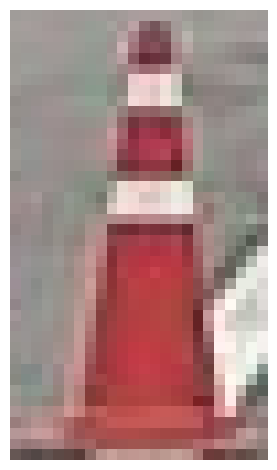

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# workspace/ 에 test.jpg 를 올려두고 테스트
img = Image.open("./test4.jpg").convert("RGB")
img_tensor = preprocess_det(img).to(device)

with torch.no_grad():
    out = detector([img_tensor])[0]
label = out['labels']
print(label)
# 가장 높은 score의 바운딩박스
scores = out['scores']
print(scores)
if len(scores)>0:
    idx = torch.argmax(scores).item()
    box = out['boxes'][idx].cpu().numpy().astype(int)
    print("Best box:", box, "score:", scores[idx].item())
    
    # 크롭
    crop = img.crop((box[0], box[1], box[2], box[3]))
    # 분류 테스트
    input_crop = preprocess_clf(crop).unsqueeze(0).to(device)
    logits = classifier(input_crop)
    cls = torch.argmax(logits,1).item()
    print("category ID:", label[idx])
    print("Predicted class idx:", cls)

    fig, ax = plt.subplots(1)
    ax.imshow(crop)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("검출된 객체 없음")